In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F

In [153]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

cifar_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_size, testing_size = len(cifar_train_set.data), len(cifar_test_set.data)
original_train_set, original_test_set = torch.empty((training_size, 3, 32, 32), dtype=float), torch.empty((testing_size, 3, 32, 32), dtype=float)
original_train_set_label, original_test_set_label = [], []

for i, data in enumerate(cifar_train_set.data):
    data = Image.fromarray(data)
    data = transform(data)
    original_train_set[i] = data
    original_train_set_label.append(cifar_train_set.targets[i])

for i, data in enumerate(cifar_test_set.data):
    data = Image.fromarray(data)
    data = transform(data)
    original_test_set[i] = data
    original_test_set_label.append(cifar_test_set.targets[i]) 

original_train_set_label, original_test_set_label = F.one_hot(torch.tensor(original_train_set_label)), F.one_hot(torch.tensor(original_test_set_label))


Files already downloaded and verified
Files already downloaded and verified


In [251]:
import random
import math

class Mixer:
    
    def mix_images_bc(self, img1, img2):
        #First between class mixing method proposed
        ratio = random.uniform(0, 1)
        mixed_image = img1 * ratio + img2 * (1 - ratio)

        return mixed_image, ratio

    def mix_images_bc_plus(self, img1, img2):
        #Better mixing method
        ratio = random.uniform(0, 1)
        i1_mean, i2_mean = torch.mean(img1), torch.mean(img2)
        i1_std, i2_std = torch.std(img1), torch.std(img2)
        p = 1 / (1 + (i1_std / i2_std) * ((1 - ratio) / ratio)) 

        mixed_image = (p * (img1 - i1_mean) + (1 - p) * (img2 - i2_mean)) / (math.sqrt(p ** 2 + (1 - p) ** 2))
        return mixed_image, ratio

        return

    def mix_image_dataset(self, images, labels, algo="bc"):
        mixed_images = torch.empty(images.shape)
        mix_ratios = torch.empty((images.shape[0], len(labels[0])))
        mixing_algo = self.mix_images_bc_plus if algo == "bc+" else self.mix_images_bc
        total = 0

        random.seed(10)
        for offset in range(1, 100):
            if total >= images.shape[0]: break
            for i in range(images.shape[0] - 1):
                if total >= images.shape[0]: break
                if i + offset < images.shape[0] and not torch.all(torch.eq(labels[i], labels[i + offset])):
                    m_i, ratio = mixing_algo(images[i], images[i + offset])
                    mixed_images[i] = m_i
                    mix_ratios[i] = torch.mul(labels[i],ratio) + torch.mul(labels[i + offset],(1 - ratio))
                    total += 1

        
        return mixed_images, mix_ratios
            
                

In [252]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [253]:
mixer = Mixer()

mixed_train_images, mixed_train_labels = mixer.mix_image_dataset(original_train_set, original_train_set_label, algo="bc")
plus_mixed_train_images, plus_mixed_train_labels = mixer.mix_image_dataset(original_train_set, original_train_set_label, algo="bc+") 

mixed_test_images, mixed_test_labels = mixer.mix_image_dataset(original_test_set, original_test_set_label, algo="bc")
plus_mixed_test_images, plus_mixed_test_labels = mixer.mix_image_dataset(original_test_set, original_test_set_label, algo="bc+") 

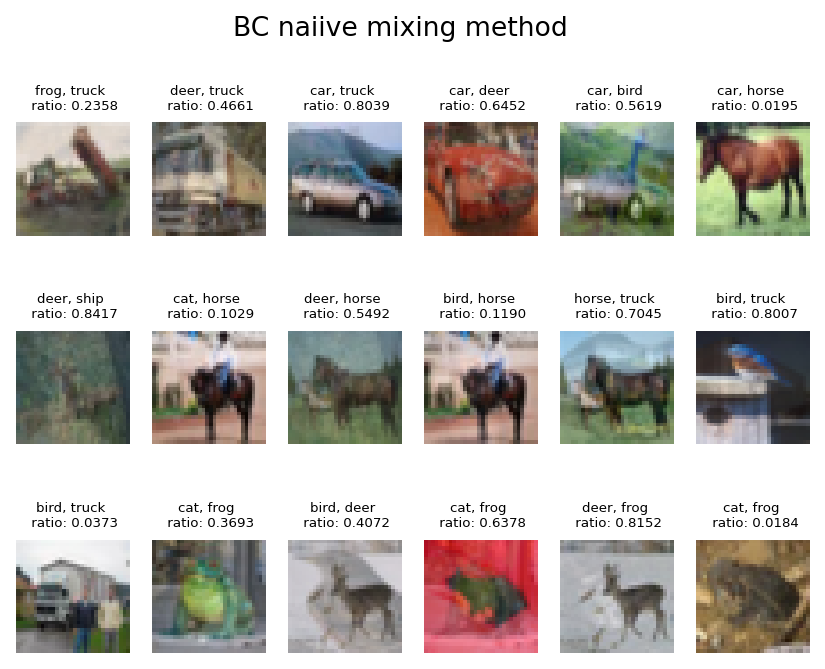

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

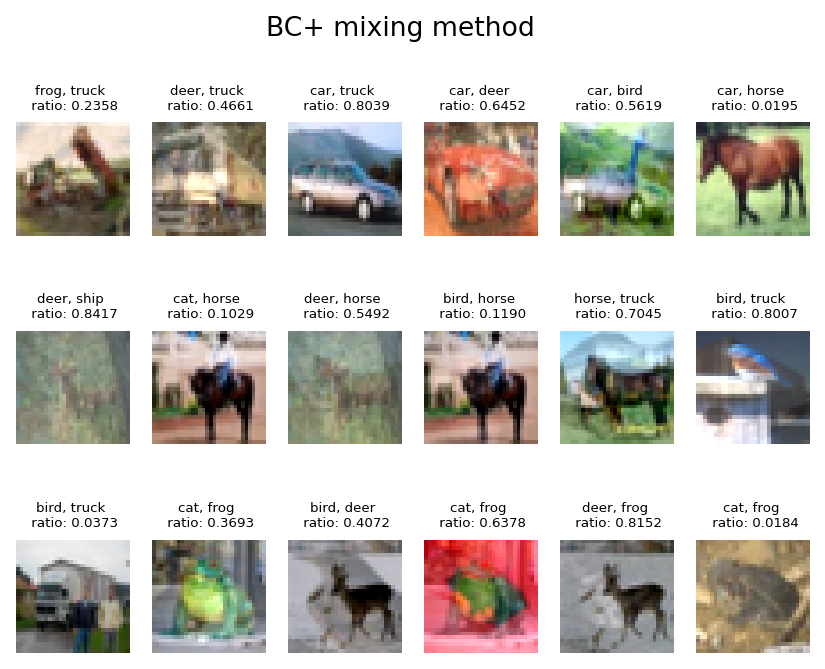

In [254]:
#Preview of the images within our mixed images
#BC naiive mixing method plot
fig, axs = plt.subplots(3, 6)
fig.set_dpi(160)
fig.suptitle("BC naiive mixing method")
for i in range(3):
    for j in range(6):
        r_index = i * 8 + j
        img = mixed_train_images[r_index] / 2 + 0.5
        axs[i, j].imshow(np.transpose(img, (1, 2,0)))
        axs[i, j].axis('off')
        image_label = torch.nonzero(mixed_train_labels[r_index])
        axs[i,j].set_title("{}, {} \n ratio: {:.4f}".format(classes[image_label[0]],classes[image_label[1]], float(mixed_train_labels[r_index][image_label[0]])),
        fontdict={'fontsize':6})

plt.show()

#BC+ mixing method plot
fig, axs = plt.subplots(3, 6)
fig.set_dpi(160)
fig.suptitle("BC+ mixing method")
for i in range(3):
    for j in range(6):
        r_index = i * 8 + j
        img = plus_mixed_train_images[r_index] / 2 + 0.5
        axs[i, j].imshow(np.transpose(img, (1, 2,0)))
        axs[i, j].axis('off')
        image_label = torch.nonzero(plus_mixed_train_labels[r_index])
        axs[i,j].set_title("{}, {} \n ratio: {:.4f}".format(classes[image_label[0]],classes[image_label[1]], float(plus_mixed_train_labels[r_index][image_label[0]])),
        fontdict={'fontsize':6})

plt.show()

In [249]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DatasetIterator(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.transform = transforms.Compose([transforms.ToTensor()])
  
    def __len__(self):
        return self.images.shape[0]
  
    def __getitem__(self, index):
        # return self.transform(self.images[index]), self.transform(self.labels[index])
        return self.images[index].detach().cpu().numpy(), self.labels[index].detach().cpu().numpy()

In [250]:
class ModelManager:
    def __init__(self, classifier, optimizer, l_function):
        self.classifier = classifier
        self.optimizer = optimizer
        self.l_function = l_function
    
    def train(self, train_loader):
        self.classifier.train()
        for batch_idx, (images, targets) in enumerate(train_loader):
            self.optimizer.zero_grad()
            output = self.classifier(images)
            loss = self.l_function(output.to(torch.float32), targets.to(torch.float32))
            loss.backward()
            self.optimizer.step()

            if not batch_idx % 100:
                print(f"Current Loss: {loss.item()}")
    
    def test(self, test_loader):
        correct, total = 0, 0
        
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                images, labels = data
                outputs = self.classifier(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                # print(predicted, torch.max(labels, 1), labels)
                correct += (predicted == torch.max(labels, 1))
        
        print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

In [247]:
#Training a model now
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn

resnet18 = models.resnet18(pretrained = True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, mixed_train_labels[0].shape[0])
resnet18.layer4.requires_grad = True
resnet18.layer3.requires_grad = True

optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.8)
# criterion = nn.KLDivLoss(reduction="batchmean")
criterion = nn.CrossEntropyLoss()

/Users/werunm/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/werunm/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [248]:
resnet18_model_manager = ModelManager(resnet18, optimizer=optimizer, l_function=criterion)

cifar10_dataset = DatasetIterator(mixed_train_images, original_train_set_label)
train_loader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=4, shuffle=True)

epochs = 30

for e in range(epochs):
    resnet18_model_manager.train(train_loader) 

Current Loss: 2.7871100902557373
Current Loss: 2.9604403972625732
Current Loss: 2.327127695083618
Current Loss: 2.164656162261963
Current Loss: 2.426908016204834
Current Loss: 3.00484037399292
Current Loss: 2.4104533195495605
Current Loss: 2.326613187789917
Current Loss: 2.8755457401275635
Current Loss: 2.8031139373779297
Current Loss: 2.4036903381347656
Current Loss: 2.541390895843506
Current Loss: 2.5419411659240723
Current Loss: 2.2639098167419434
Current Loss: 3.7932021617889404
Current Loss: 2.9362850189208984
Current Loss: 2.0936992168426514
Current Loss: 2.4861395359039307
Current Loss: 3.2945616245269775
Current Loss: 2.143110752105713
Current Loss: 1.935426950454712
Current Loss: 2.4623677730560303
Current Loss: 2.772779941558838
Current Loss: 1.8128821849822998
Current Loss: 2.2902095317840576
Current Loss: 2.276944875717163
Current Loss: 2.2612204551696777
Current Loss: 2.342240333557129
Current Loss: 2.8058085441589355
Current Loss: 2.51957106590271
Current Loss: 2.18994426

KeyboardInterrupt: 

In [245]:
cifar10_test_dataset = DatasetIterator(mixed_test_images, mixed_test_labels)
test_loader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size=4, shuffle=False)
resnet18_model_manager.test(test_loader) 

Accuracy of the network on the test images: 0 %
